<h1> Initial

<h2> Import and Download

In [0]:
import tensorflow
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()



<h2> Visualize the data

In [0]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)


print(x_train.shape[0], 'train set')
print(x_test.shape[0], 'test set')


Cifar_labels = ["Airplane",  # index 0
                        "Automobile",      # index 1
                        "Bird",     # index 2 
                        "Cat",        # index 3 
                        "Deer",         # index 4
                        "Dog",       # index 5
                        "Frog",        # index 6 
                        "Horse",      # index 7 
                        "Ship",          # index 8 
                        "Truck"]   # index 9


img_index = 5

label_index = y_train[img_index]

print ("y = " + str(label_index) + " " +(Cifar_labels[label_index[0]]))

plt.imshow(x_train[img_index])

<h2> Pre-Process

In [0]:
num_classes = 10

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

<h1> Classifier

<h2> Model

In [0]:
batch_size = 64
epochs = 50
model_name = 'cifar10_model'
save_dir = '/model/' + model_name

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

<h2> Train

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model_Cifar.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1,
          shuffle=True,
         callbacks=[checkpointer])

<h2> Load Model with the best validation accuracy

In [0]:
# Load the weights with the best validation accuracy
model.load_weights('model_Cifar.weights.best.hdf5')

<h2> Test Accuracy

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

<h2> Visualize Prediction

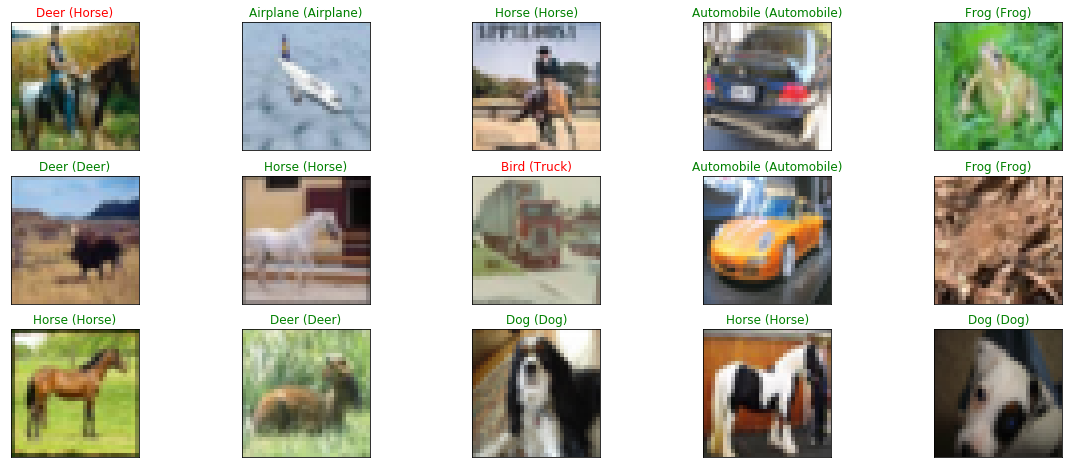

In [0]:
import matplotlib.pyplot as plt

y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(Cifar_labels[predict_index], 
                                  Cifar_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

<h1> Lipschitz Constrained Classifier

<h2> Outputs of Pre-final layer (i.e. just before softmax)

In [0]:
get_12th_layer_output = K.function([model.layers[0].input],
                                  [model.layers[9].output])
layer_output = get_12th_layer_output([x_train])[0]
np.save("output.npy", layer_output)

<h2>A custom layer to apply Lipscitz Constrain

In [0]:
class SpectralDecay(Regularizer):
    
    def __init__(self, sd_lambda, iterations=2):
        self.sd_lambda = sd_lambda
        self.iterations = iterations
    
    def __call__(self, w):
        if self.sd_lambda == 0:
            return 0
        else:
            w = K.reshape(w, [-1, w.shape.as_list()[-1]])
            x = K.random_normal_variable(shape=(int(w.shape[1]), 1), mean=0, scale=1)

            for i in range(0, self.iterations): 
                x_p = K.dot(w, x)
                x = K.dot(K.transpose(w), x_p)
            
            return self.sd_lambda * K.sum(K.pow(K.dot(w, x), 2.0)) / K.sum(K.pow(x, 2.0))
    
    def get_config(self):
        return {
            "sd_lambda": self.sd_lambda,
            "iterations": self.iterations
        }

<h2> Model

In [0]:
batch_size = 64
epochs = 50
model_name = 'cifar10_model'
save_dir = '/model/' + model_name

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(SpectralDecay())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(SpectralDecay())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(SpectralDecay())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256))
model.add(SpectralDecay())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

<h2> Train

In [0]:
model.compile(loss='mean_squared_error',
             optimizer='adam'
             )


from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model_fmnist.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train,layer_output ,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1,
          shuffle=True,
         callbacks=[checkpointer])

<h1> Attacks

<h2>FGSM

In [0]:
sess = K.get_session()
# Initialize adversarial example with input image
x_adv = x_train[100]
# Added noise
x_noise = np.zeros_like(x)

# Choose target class
epsilon = 0.1
target_class = 0 
prev_probs = []

In [0]:
step_size = 0.05

target = K.one_hot(target_class, 10)

loss = -1*K.categorical_crossentropy(target, model.output)

grads = K.gradients(loss, model.input)

delta = K.sign(grads[0])

x_noise = x_noise + delta


x_adv = x_adv + epsilon*delta

# Get the new image and predictions
x_adv = sess.run(x_adv, feed_dict={model.input:x})
preds = model.predict(x_adv)

Ad_img = image + noise
Ad_img = np.clip(a=noisy_img, a_min=0.0, a_max=1.0)
gradients = k.gradients(loss, noise)
noise -= step_size*gradients

<h2> Carlini-Wagner Attack

In [0]:
MAX_ITERATIONS = 1000   
ABORT_EARLY = True      
LEARNING_RATE = 1e-2    
INITIAL_CONST = 1e-3    
LARGEST_CONST = 2e6     
REDUCE_CONST = False    
TARGETED = True         
CONST_FACTOR = 2.0      

In [0]:
class CarliniL0:
    def __init__(self, sess, model,
                 targeted = TARGETED, learning_rate = LEARNING_RATE,
                 max_iterations = MAX_ITERATIONS, abort_early = ABORT_EARLY,
                 initial_const = INITIAL_CONST, largest_const = LARGEST_CONST,
                 reduce_const = REDUCE_CONST, const_factor = CONST_FACTOR,
                 independent_channels = False):
        self.model = model
        self.sess = sess

        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.ABORT_EARLY = abort_early
        self.INITIAL_CONST = initial_const
        self.LARGEST_CONST = largest_const
        self.REDUCE_CONST = reduce_const
        self.const_factor = const_factor
        self.independent_channels = independent_channels

        self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = False

        self.grad = self.gradient_descent(sess, model)

    def gradient_descent(self, sess, model):
        def compare(x,y):
            if self.TARGETED:
                return x == y
            else:
                return x != y
        shape = (1,model.image_size,model.image_size,model.num_channels)
        
        # the variable to optimize over
        modifier = tf.Variable(np.zeros(shape,dtype=np.float32))

        # the variables we're going to hold, use for efficiency
        canchange = tf.Variable(np.zeros(shape),dtype=np.float32)
        simg = tf.Variable(np.zeros(shape,dtype=np.float32))
        original = tf.Variable(np.zeros(shape,dtype=np.float32))
        timg = tf.Variable(np.zeros(shape,dtype=np.float32))
        tlab = tf.Variable(np.zeros((1,model.num_labels),dtype=np.float32))
        const = tf.placeholder(tf.float32, [])

        # and the assignment to set the variables
        assign_modifier = tf.placeholder(np.float32,shape)
        assign_canchange = tf.placeholder(np.float32,shape)
        assign_simg = tf.placeholder(np.float32,shape)
        assign_original = tf.placeholder(np.float32,shape)
        assign_timg = tf.placeholder(np.float32,shape)
        assign_tlab = tf.placeholder(np.float32,(1,self.model.num_labels))

        # these are the variables to initialize when we run
        set_modifier = tf.assign(modifier, assign_modifier)
        setup = []
        setup.append(tf.assign(canchange, assign_canchange))
        setup.append(tf.assign(timg, assign_timg))
        setup.append(tf.assign(original, assign_original))
        setup.append(tf.assign(simg, assign_simg))
        setup.append(tf.assign(tlab, assign_tlab))
        
        newimg = (tf.tanh(modifier + simg)/2)*canchange+(1-canchange)*original
        
        output = model.predict(newimg)
        
        real = tf.reduce_sum((tlab)*output,1)
        other = tf.reduce_max((1-tlab)*output - (tlab*10000),1)
        if self.TARGETED:
            # if targetted, optimize for making the other class most likely
            loss1 = tf.maximum(0.0, other-real+.01)
        else:
            # if untargeted, optimize for making this class least likely.
            loss1 = tf.maximum(0.0, real-other+.01)
            
        loss2 = tf.reduce_sum(tf.square(newimg-tf.tanh(timg)/2))
        loss = const*loss1+loss2
            
        outgrad = tf.gradients(loss, [modifier])[0]
        
        # setup the adam optimizer and keep track of variables we're creating
        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)
        train = optimizer.minimize(loss, var_list=[modifier])

        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]
        init = tf.variables_initializer(var_list=[modifier,canchange,simg,
                                                  original,timg,tlab]+new_vars)

        
        def doit(oimgs, labs, starts, valid, CONST):
            # convert to tanh-space
            imgs = np.arctanh(np.array(oimgs)*1.999999)
            starts = np.arctanh(np.array(starts)*1.999999)

            # initialize the variables
            sess.run(init)
            sess.run(setup, {assign_timg: imgs, 
                                    assign_tlab:labs, 
                                    assign_simg: starts, 
                                    assign_original: oimgs,
                                    assign_canchange: valid})

            while CONST < self.LARGEST_CONST:
                # try solving for each value of the constant
                print('try const', CONST)
                for step in range(self.MAX_ITERATIONS):
                    feed_dict={const: CONST}
                    
            # remember the old value
                    oldmodifier = self.sess.run(modifier)

                    if step%(self.MAX_ITERATIONS//10) == 0:
                        print(step,*sess.run((loss1,loss2),feed_dict=feed_dict))

                    # perform the update step
                    _, works, scores = sess.run([train, loss1, output], feed_dict=feed_dict)

                    if np.all(scores>=-.0001) and np.all(scores <= 1.0001):
                        if np.allclose(np.sum(scores,axis=1), 1.0, atol=1e-3):
                            if not self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK:
                                raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = True")
                    
                    if works < .0001 and self.ABORT_EARLY:
                        # it worked previously, restore the old value and finish
                        self.sess.run(set_modifier, {assign_modifier: oldmodifier})
                        grads, scores, nimg = sess.run((outgrad, output,newimg),
                                                       feed_dict=feed_dict)

                        l2s=np.square(nimg-np.tanh(imgs)/2).sum(axis=(1,2,3))
                        return grads, scores, nimg, CONST

                # we didn't succeed, increase constant and try again
                CONST *= self.const_factor
        return doit
        
    def attack(self, imgs, targets):
        r = []
        for i,(img,target) in enumerate(zip(imgs, targets)):
            print("Attack iteration",i)
            r.extend(self.attack_single(img, target))
        return np.array(r)

    def attack_single(self, img, target):
        """
        Run the attack on a single image and label
        """

        # the pixels we can change
        valid = np.ones((1,self.model.image_size,self.model.image_size,self.model.num_channels))

        # the previous image
        prev = np.copy(img).reshape((1,self.model.image_size,self.model.image_size,
                                     self.model.num_channels))

        # initially set the solution to None, if we can't find an adversarial
        # example then we will return None as the solution.
        last_solution = None
        const = self.INITIAL_CONST

        equal_count = None
    
        while True:
            # try to solve given this valid map
            res = self.grad([np.copy(img)], [target], np.copy(prev), 
                       valid, const)
            if res == None:
                # the attack failed, we return this as our final answer
                print("Final answer",equal_count)
                return last_solution
    
            # the attack succeeded, now we pick new pixels to set to 0
            restarted = False
            gradientnorm, scores, nimg, const = res
            if self.REDUCE_CONST: const /= 2
    
            equal_count = self.model.image_size**2-np.sum(np.all(np.abs(img-nimg[0])<.0001,axis=2))
            print("Forced equal:",np.sum(1-valid),
                  "Equal count:",equal_count)
            if np.sum(valid) == 0:
                # if no pixels changed, return 
                return [img]
    
            if self.independent_channels:
                # we are allowed to change each channel independently
                valid = valid.flatten()
                totalchange = abs(nimg[0]-img)*np.abs(gradientnorm[0])
            else:
                # we care only about which pixels change, not channels independently
                # compute total change as sum of change for each channel
                valid = valid.reshape((self.model.image_size**2,self.model.num_channels))
                totalchange = abs(np.sum(nimg[0]-img,axis=2))*np.sum(np.abs(gradientnorm[0]),axis=2)
            totalchange = totalchange.flatten()

            # set some of the pixels to 0 depending on their total change
            did = 0
            for e in np.argsort(totalchange):
                if np.all(valid[e]):
                    did += 1
                    valid[e] = 0

                    if totalchange[e] > .01:
                        # if this pixel changed a lot, skip
                        break
                    if did >= .3*equal_count**.5:
                        # if we changed too many pixels, skip
                        break

            valid = np.reshape(valid,(1,self.model.image_size,self.model.image_size,-1))
            print("Now forced equal:",np.sum(1-valid))
    
            last_solution = prev = nimg